In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan #for homestacity
from statsmodels.stats.stattools import durbin_watson #for indepence
np.random.seed(773)
import kagglehub
import pymc as pm
import arviz as az

# Data Preprocessing

In [39]:
df = pd.read_csv('U.S._Chronic_Disease_Indicators__CDI___2023_Release.csv')
df

/tmp/ipython-input-3826564063.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/u-s-chronic-disease-indicators-cdi-2023-release/U.S._Chronic_Disease_Indicators__CDI___2023_Release.csv')


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,5,AST,AST3_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,8,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,11,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,13,AST,AST3_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,26,AST,AST3_1,NMBR,RACE,HIS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185671,2020,2020,WY,Wyoming,BRFSS,Diabetes,Dilated eye examination among adults aged >= 1...,NaN,%,Age-adjusted Prevalence,...,56,DIA,DIA7_0,AGEADJPREV,RACE,WHT,NaN,NaN,NaN,NaN
1185672,2020,2020,WY,Wyoming,BRFSS,Older Adults,Proportion of older adults aged >= 65 years wh...,NaN,%,Crude Prevalence,...,56,OLD,OLD3_1,CRDPREV,RACE,WHT,NaN,NaN,NaN,NaN
1185673,2017,2017,IA,Iowa,BRFSS,Arthritis,Activity limitation due to arthritis among adu...,NaN,%,Age-adjusted Prevalence,...,19,ART,ART2_1,AGEADJPREV,RACE,HIS,NaN,NaN,NaN,NaN
1185674,2020,2020,WY,Wyoming,BRFSS,Diabetes,Diabetes prevalence among women aged 18-44 years,NaN,%,Crude Prevalence,...,56,DIA,DIA2_2,CRDPREV,RACE,HIS,NaN,NaN,NaN,NaN


In [40]:
#assigns regions to each state based on US Census Bureau nine divisions
def get_region(t):
    if t in ["CT", "ME", "MA", "NH", "RI", "VT"]:
        return 'Northeast'
    elif t in ["NJ", "NY", "PA"]:
        return 'Mid-Atlantic'
    elif t in ["IL", "IN", "MI", "OH", "WI"]:
        return 'Midwest (East North Central)'
    elif t in ["IA", "KS", "MN", "MO", "NE", "ND", "SD"]:
        return 'Midwest (West North Central)'
    elif t in ["DE", "DC", "FL", "GA", "MD", "NC", "SC", "VA", "WV"]:
        return 'South (South Atlantic)'
    elif t in ["AL", "KY", "MS", "TN"]:
        return 'South (East South Central)'
    elif t in ["AR", "LA", "OK", "TX"]:
        return 'South (West South Central)'
    elif t in ["AZ", "CO", "ID", "MT", "NV", "NM", "UT", "WY"]:
        return 'West (Mountain)'
    elif t in ["AK", "CA", "HI", "OR", "WA"]:
        return 'Pacific'
    elif t == 'US':
      return 'United States'
    else:
        return 'Unknown Region'

/tmp/ipython-input-645081256.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('U.S._Chronic_Disease_Indicators__CDI___2023_Release.csv')


In [41]:
#cleaning and filtering the data for asthma
df_a = df[df['Topic'] == 'Asthma']
df_a = df_a[df_a['Question'] == 'Current asthma prevalence among adults aged >= 18 years']
df_a = df_a[df_a['DataValueType'] == 'Crude Prevalence']
df_a = df_a[df_a['StratificationCategoryID1'] == 'OVERALL']
df_a = df_a[df_a['DataValueUnit'] == '%']
df_a['Region'] = df_a['LocationAbbr'].apply(get_region)
df_a = df_a[df_a['Region'] != 'Unknown Region']
df_a

['Hospitalizations for asthma' 'Asthma mortality rate'
 'Cancer of the oral cavity and pharynx, mortality'
 'Cancer of the prostate, mortality'
 'Invasive cancer (all sites combined), mortality'
 'Cancer of the female breast, mortality'
 'Cancer of the female cervix, mortality'
 'Cancer of the colon and rectum (colorectal), mortality'
 'Cancer of the lung and bronchus, mortality'
 'Invasive melanoma, incidence' 'Melanoma, mortality'
 'Mortality with end-stage renal disease'
 'Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis'
 'Hospitalization for chronic obstructive pulmonary disease as any diagnosis'
 'Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis among Medicare-eligible persons aged >= 65 years'
 'Hospitalization for chronic obstructive pulmonary disease as any diagnosis among Medicare-eligible persons aged >= 65 years'
 'Mortality from heart failure'
 'Hospitalization for heart failure among Medicare-eligible p

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3,Region
529650,2020,2020,AK,Alaska,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Crude Prevalence,...,AST,AST1_1,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Pacific
530123,2015,2015,AK,Alaska,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Crude Prevalence,...,AST,AST1_1,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Pacific
532773,2021,2021,AK,Alaska,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Crude Prevalence,...,AST,AST1_1,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Pacific
536483,2011,2011,AK,Alaska,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Crude Prevalence,...,AST,AST1_1,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Pacific
536953,2017,2017,AK,Alaska,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Crude Prevalence,...,AST,AST1_1,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175569,2021,2021,WY,Wyoming,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Crude Prevalence,...,AST,AST1_1,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,West (Mountain)
1175990,2018,2018,WY,Wyoming,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Crude Prevalence,...,AST,AST1_1,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,West (Mountain)
1180332,2016,2016,WY,Wyoming,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Crude Prevalence,...,AST,AST1_1,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,West (Mountain)
1180507,2012,2012,WY,Wyoming,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Crude Prevalence,...,AST,AST1_1,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,West (Mountain)


In [42]:
df_asth = df_a[['YearStart','LocationDesc','LocationAbbr','DataValue','LowConfidenceLimit', 'HighConfidenceLimit', 'Region']]
df_asth = df_asth.reset_index(drop=True)
df_asth['LocationDesc'] = df_asth["LocationDesc"].astype(str)
df_asth["YearStart"] = df_asth["YearStart"].astype(int)
df_asth = df_asth.rename(columns={'YearStart':'Year',
                'LocationDesc':'State',
                'DataValue':'Asthma_Prev'})
df_asth = df_asth.dropna()
df_asth["Asthma_Prev"] = pd.to_numeric(df_asth["Asthma_Prev"])
df_asth

,Year,State,LocationAbbr,Asthma_Prev,LowConfidenceLimit,HighConfidenceLimit,Region
0,2020,Alaska,AK,8.9,7.4,10.5,Pacific
1,2015,Alaska,AK,9.2,7.7,11.1,Pacific
2,2021,Alaska,AK,9.0,7.9,10.2,Pacific
3,2011,Alaska,AK,8.2,7.0,9.5,Pacific
4,2017,Alaska,AK,8.4,6.9,10.3,Pacific
...,...,...,...,...,...,...,...
567,2021,Wyoming,WY,9.7,8.5,11.1,West (Mountain)
568,2018,Wyoming,WY,8.7,7.7,9.8,West (Mountain)
569,2016,Wyoming,WY,9.5,8.2,11.1,West (Mountain)
570,2012,Wyoming,WY,9.0,7.9,10.3,West (Mountain)


In [43]:
#cleaning and filtering the data for Smoking
df_s = df[df['Topic'] == 'Tobacco']
df_s = df_s[df_s['Question'] == ('Current smoking among adults aged >= 18 years')]
df_s = df_s[df_s['DataValueType'] == 'Crude Prevalence']
df_s = df_s[df_s['StratificationCategoryID1'] == 'OVERALL']
df_s = df_s[df_s['DataValueUnit'] == '%']
df_s['Region'] = df_s['LocationAbbr'].apply(get_region)
df_s = df_s[df_s['Region'] != 'Unknown Region']
df_s

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3,Region
529474,2019,2019,AK,Alaska,BRFSS,Tobacco,Current smoking among adults aged >= 18 years,NaN,%,Crude Prevalence,...,TOB,TOB1_2,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Pacific
530033,2014,2014,AK,Alaska,BRFSS,Tobacco,Current smoking among adults aged >= 18 years,NaN,%,Crude Prevalence,...,TOB,TOB1_2,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Pacific
530761,2016,2016,AK,Alaska,BRFSS,Tobacco,Current smoking among adults aged >= 18 years,NaN,%,Crude Prevalence,...,TOB,TOB1_2,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Pacific
531189,2021,2021,AL,Alabama,BRFSS,Tobacco,Current smoking among adults aged >= 18 years,NaN,%,Crude Prevalence,...,TOB,TOB1_2,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,South (East South Central)
531845,2011,2011,AK,Alaska,BRFSS,Tobacco,Current smoking among adults aged >= 18 years,NaN,%,Crude Prevalence,...,TOB,TOB1_2,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182584,2016,2016,WY,Wyoming,BRFSS,Tobacco,Current smoking among adults aged >= 18 years,NaN,%,Crude Prevalence,...,TOB,TOB1_2,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,West (Mountain)
1184022,2018,2018,WY,Wyoming,BRFSS,Tobacco,Current smoking among adults aged >= 18 years,NaN,%,Crude Prevalence,...,TOB,TOB1_2,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,West (Mountain)
1184707,2019,2019,WY,Wyoming,BRFSS,Tobacco,Current smoking among adults aged >= 18 years,NaN,%,Crude Prevalence,...,TOB,TOB1_2,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,West (Mountain)
1184823,2017,2017,WY,Wyoming,BRFSS,Tobacco,Current smoking among adults aged >= 18 years,NaN,%,Crude Prevalence,...,TOB,TOB1_2,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,West (Mountain)


In [44]:
df_s = df_s[['YearStart','LocationDesc','LocationAbbr','DataValue','LowConfidenceLimit', 'HighConfidenceLimit','Region']]
df_smok = df_s.reset_index(drop=True)
df_smok['LocationDesc'] = df_smok["LocationDesc"].astype(str)
df_smok["YearStart"] = df_smok["YearStart"].astype(int)
df_smok = df_smok.rename(columns={'YearStart':'Year',
                'LocationDesc':'State',
                'DataValue':'Smoking_Prev'})

df_smok = df_smok.dropna()
df_smok["Smoking_Prev"] = pd.to_numeric(df_smok["Smoking_Prev"])
df_smok

,Year,State,LocationAbbr,Smoking_Prev,LowConfidenceLimit,HighConfidenceLimit,Region
0,2019,Alaska,AK,17.4,15.3,19.8,Pacific
1,2014,Alaska,AK,19.9,18.2,21.6,Pacific
2,2016,Alaska,AK,19.0,16.9,21.4,Pacific
3,2021,Alabama,AL,17.2,15.7,18.9,South (East South Central)
4,2011,Alaska,AK,22.9,21.0,25.0,Pacific
...,...,...,...,...,...,...,...
567,2016,Wyoming,WY,18.9,17.1,21.0,West (Mountain)
568,2018,Wyoming,WY,18.8,17.3,20.4,West (Mountain)
569,2019,Wyoming,WY,18.4,16.7,20.2,West (Mountain)
570,2017,Wyoming,WY,18.7,17.2,20.3,West (Mountain)


# EDA

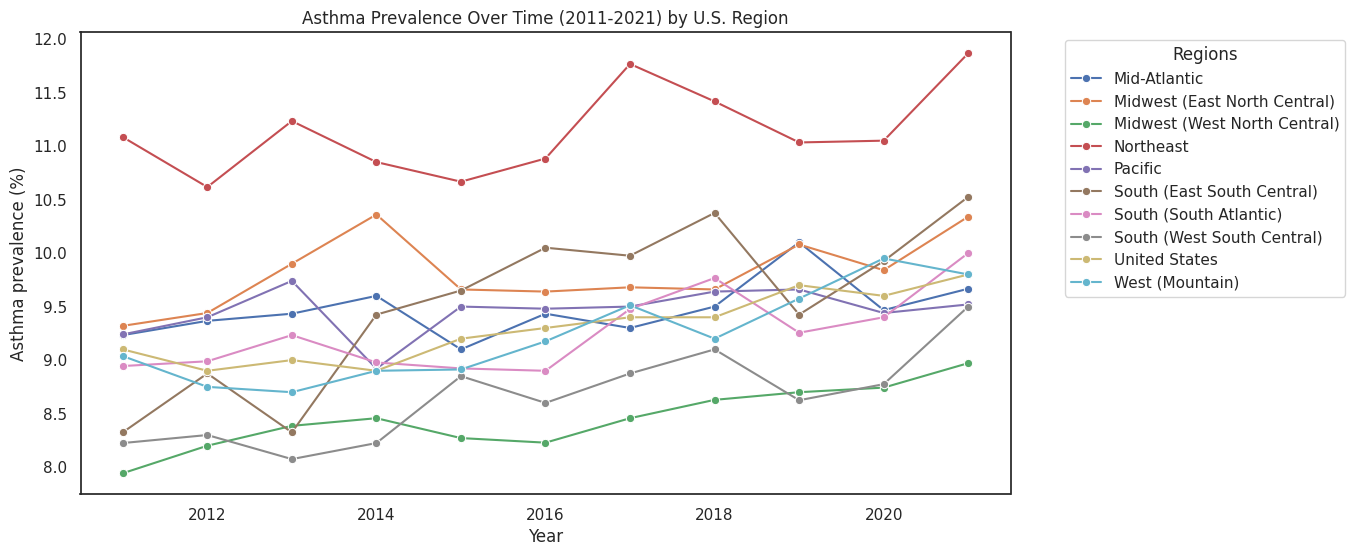

In [45]:
#setting the theme for all the graphs
sns.set_theme(style='white', )
# plotting Asthma Prevalence Over Time by U.S. Region
region = df_asth.groupby(['Year', 'Region'], as_index=False).Asthma_Prev.mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=region,x='Year',y='Asthma_Prev',hue='Region',marker='o')

plt.xlabel("Year")
plt.ylabel("Asthma prevalence (%)")
plt.title("Asthma Prevalence Over Time (2011-2021) by U.S. Region")
plt.legend(title="Regions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

*Figure 1. Asthma Prevalence Over Years by U.S. Region.*

In this figure, we plotted **asthma** prevalence over time for 10 years (2011-2021) in the U.S. Prevalence rates are aggregated by region, and each region is defined by the United States Census Bureau. We additionally plotted the national average (“United States”).

We observe that across all regions in the U.S., asthma prevalence is increasing. The Northeast region, in particular, has the highest prevalence, while the Mountain and the West South Central regions have the lowest. The remaining regions show greater variability in their asthma prevalence over time.

The visualization is relevant to our research question, which asks whether and which regions and states show a linear trend in their association between asthma and smoking prevalence. Results from this EDA suggest that on the regional scale, there are some linear trends in asthma. This motivates and justifies our later research, which will identify which states in these regions also exhibit linear associations between asthma and smoking over time.



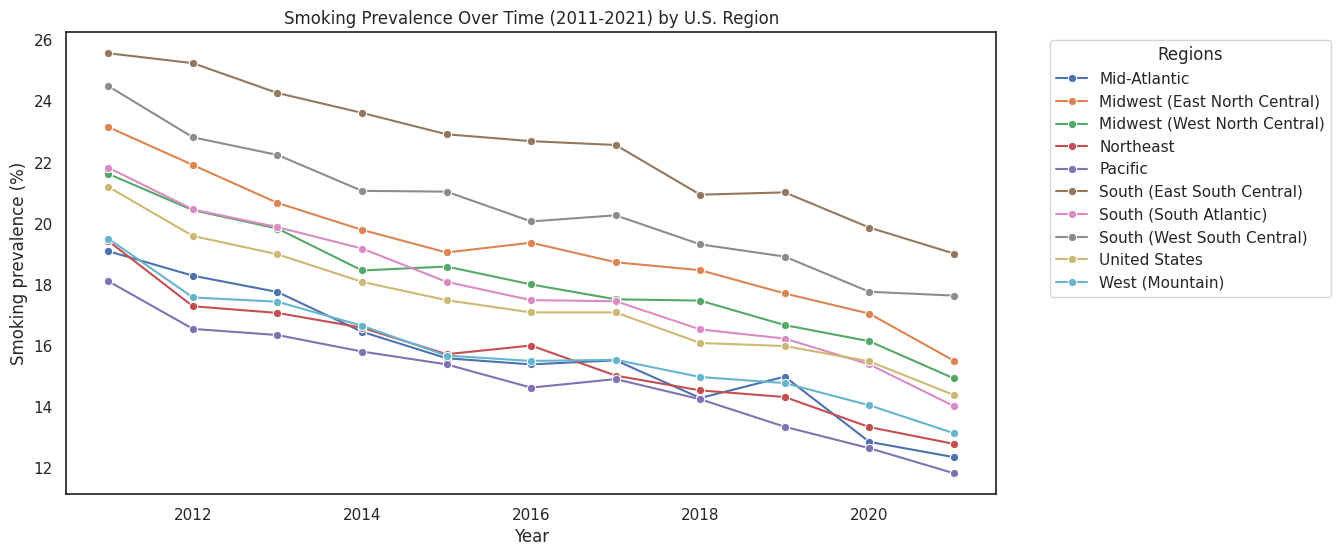

In [46]:
# plotting Smoking Prevalence Over Time by U.S. Region
region = df_smok.groupby(['Year', 'Region'], as_index=False).Smoking_Prev.mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=region,x='Year',y='Smoking_Prev',hue='Region',marker='o')

plt.xlabel("Year")
plt.ylabel("Smoking prevalence (%)")
plt.title("Smoking Prevalence Over Time (2011-2021) by U.S. Region")
plt.legend(title="Regions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

*Figure 2. Smoking Prevalence Over Years by U.S. Region.*

In this figure we visualize the trends of **smoking** prevalence from 2011-2021 aggregated by region and the United States national average. We can see that all regions have a decreasing linear trend. However there is variability in this decrease for instance some regions such as the Mid Atlantic and the Northeast show trends that increase and decrease for smoking prevalence. It is unclear which states within these regions might be responsible for this phenomenon.  This is why our research will show which states have linear relationships.

:Looking at figure one we can see that even though smoking prevalence is decreasing asthma prevalence keeps increasing. However if you take a look at the Mid Atlantic in 2019 the upward trend in asthma prevalence corresponds with a spike in the smoking prevalence graph suggesting that there is some correlation between the two variables.



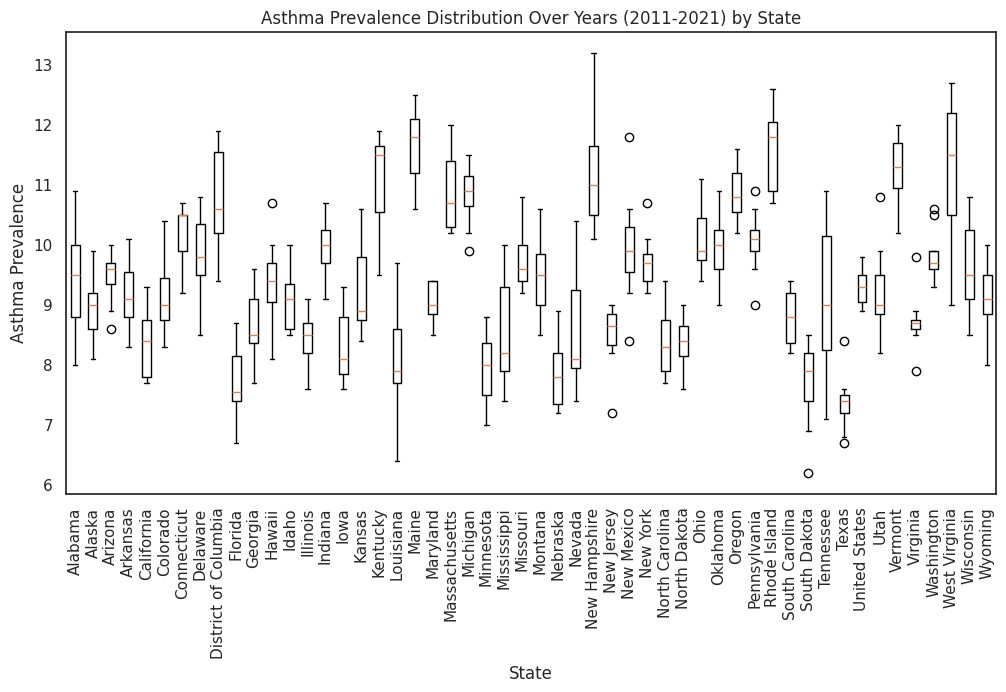

In [47]:
# plotting the Asthma Prevalence Distribution Over Years by State
groups = df_asth.groupby("State")["Asthma_Prev"].apply(list)

plt.figure(figsize=(12, 6))
plt.boxplot(groups, tick_labels=groups.index)

plt.xlabel("State")
plt.ylabel("Asthma Prevalence")
plt.title("Asthma Prevalence Distribution Over Years (2011-2021) by State")
plt.xticks(rotation=90)

plt.show()

*Figure 3. Asthma Prevalence Distribution Over Years by State.*

  In this visualization, we plot **asthma** prevalence by state from 2011-2021. We observe substantial variation in asthma prevalence across states, and that some states have much higher asthma prevalence (e.g., District of Columbia, New Hampshire) while other states have much lower prevalence (e.g., Florida, Louisiana, and Texas). We also observe a loose association between state population size and prevalence, where smaller populations tend to show more extreme (either higher or lower) prevalence. We hypothesize that these estimates are more extreme because there are fewer people/data points, and thus estimates are more easily skewed. Although the prevalence accounts for population size (and is mathematically defined as: #positive cases/#people), estimates in very small populations are more likely to appear noisy and thus less reliable.

  These observations from our EDA are directly related to our research question, which asks whether state-level asthma prevalences in adults differ after partial pooling. This visualization motivates the need for partial pooling (regional-level), because small-population states may have unreliable prevalence estimates. As a result, we will specifically investigate whether partial pooling shrinks extreme estimates in low-population states and can provide a means of generating more reliable estimates.


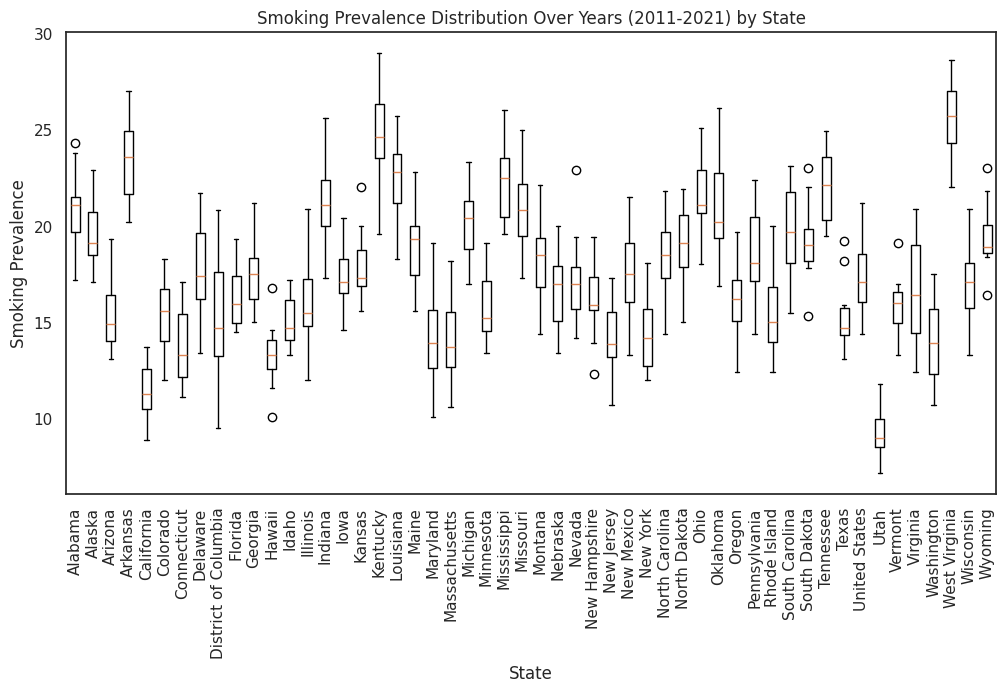

In [48]:
groups = df_smok.groupby("State")["Smoking_Prev"].apply(list)
plt.figure(figsize=(12, 6))
plt.boxplot(groups, tick_labels=groups.index)

plt.xlabel("State")
plt.ylabel("Smoking Prevalence")
plt.title("Smoking Prevalence Distribution Over Years (2011-2021) by State")
plt.xticks(rotation=90)

plt.show()

*Figure 4. Smoking Prevalence Over Years by State.*

In this visualization, we plot **smoking** prevalence by state from 2011-2021. We observe similar variability in state-level prevalence estimates as observed in asthma prevalences (Figure 3-4). When comparing the two figures jointly, there is an approximate positive association in states between smoking and asthma. However, we are not claiming that this association is significant, solely that we observe a general visual trend. Furthermore, smoking prevalence is generally higher (10-30%) in all states compared to asthma prevalence (6-13%) (Figure 3-4). Notably, Maine has the highest asthma prevalence out of all states (Figure 3), but has moderate smoking levels (Figure 4), suggesting that there may be additional factors (e.g, societal norms, environmental factors, lifestyle choices) that influence more “extreme” prevalence estimates.

 These observations directly relate to the second part of our research question, which asks what is the association between adult smoking prevalence and asthma. After applying partial pooling, we will re-examine this relationship and determine which regions reveal the strongest positive association between smoking and asthma prevalence. We are interested in identifying regions where smoking is closely linked to asthma, such that our research can help target regions where policy (e.g., public health intervention) could be most beneficial.


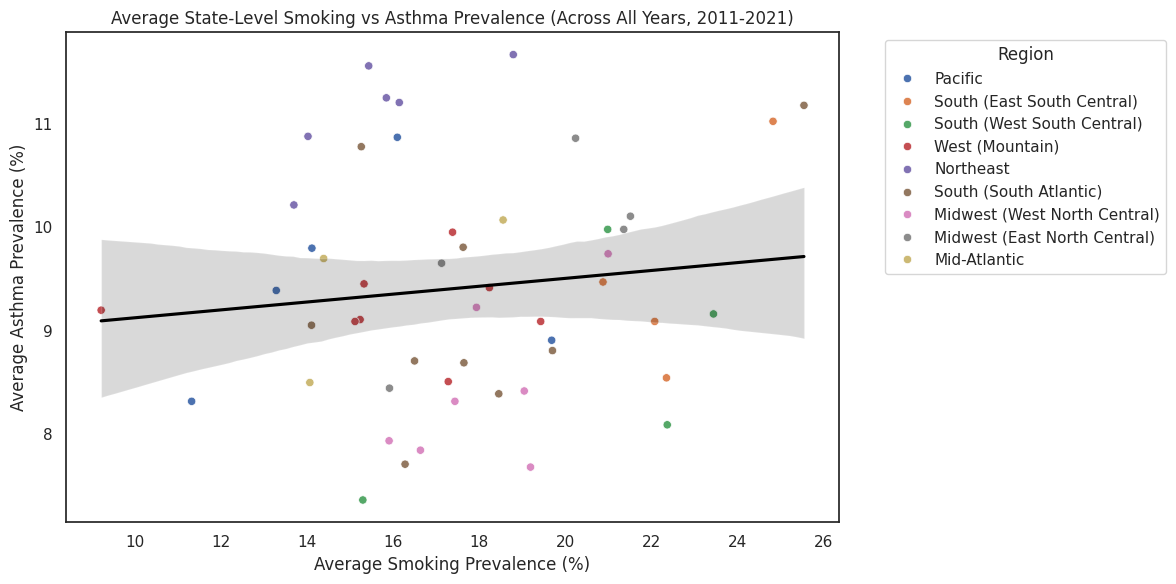

In [49]:
asth_mean = df_asth.groupby("LocationAbbr")["Asthma_Prev"].mean().rename("AsthmaMean")
smok_mean = df_smok.groupby("LocationAbbr")["Smoking_Prev"].mean().rename("SmokingMean")
avg = pd.concat([asth_mean, smok_mean], axis=1).reset_index()
avg = avg[avg["LocationAbbr"] != "US"]
avg['Region'] = avg['LocationAbbr'].apply(get_region)


plt.figure(figsize=(12, 6))
sns.scatterplot(data=avg, x="SmokingMean", y="AsthmaMean", hue="Region")
sns.regplot(data=avg,x="SmokingMean", y="AsthmaMean", scatter=False, color="black")
plt.xlabel("Average Smoking Prevalence (%)")
plt.ylabel("Average Asthma Prevalence (%)")
plt.title("Average State-Level Smoking vs Asthma Prevalence (Across All Years, 2011-2021)")


plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

*Figure 5. Average State-Level Smoking vs Asthma Prevalence (Across all Years)*

In this figure, we observe a slight positive correlation between average state-level smoking prevalence and average state-level asthma prevalence, suggesting a potential link worth further exploration. However, this relationship is weak and shows substantial scatter across the states. The fitted regression line is sloped upwards, indicating that states with higher smoking rates tend to have slightly higher asthma prevalence. This figure supports our research questions by showing that smoking may be associated with asthma prevalence. However, the association is weak, so that's why in our research we are using partial pooling to get rid of some of the state level noise.


# RQ1

In [50]:
def bonferroni_correction(p,a):
  return (p <= a/len(p)).astype(bool)


def benj_h_or_y(p,a,y=False):
  p_copy = np.array(p)
  sort_idx = np.argsort(p_copy)
  p_sort = np.sort(p_copy)
  m = len(p)

  thresh = np.arange(1,m + 1) / m * a
  if y == True:
    c_m = np.sum(1/np.arange(1,m+1))
    thresh = (np.arange(1,m + 1) / (m * c_m)) * a

  m_idx = np.where(p_sort <= thresh)[0].max() if any(p_sort <= thresh) else -1
  des = np.zeros(m,dtype=bool)
  if m_idx != -1:
    des[sort_idx[: m_idx + 1]] = True
  return des

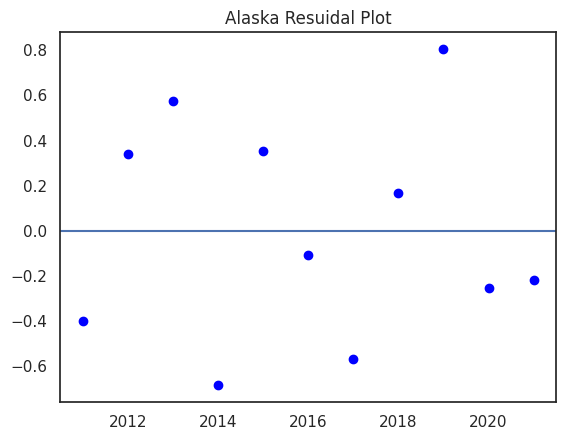

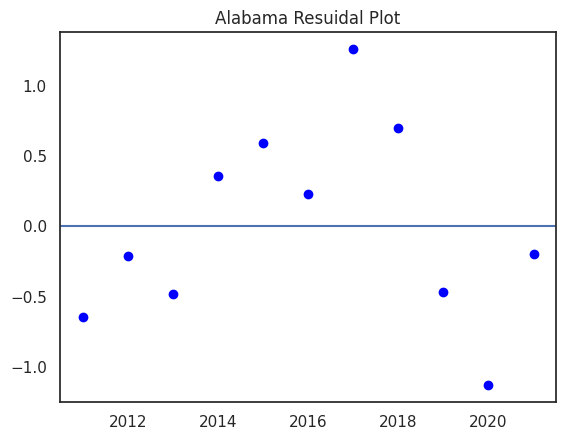

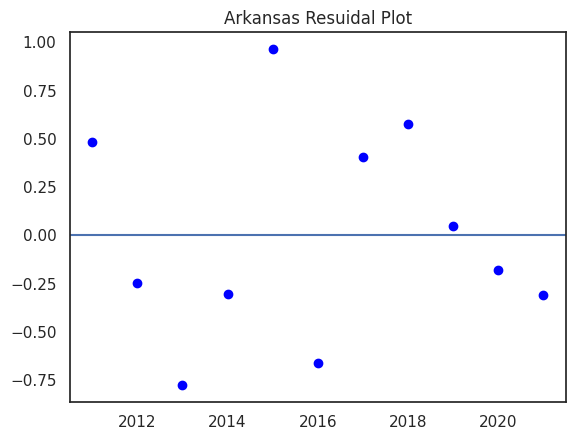

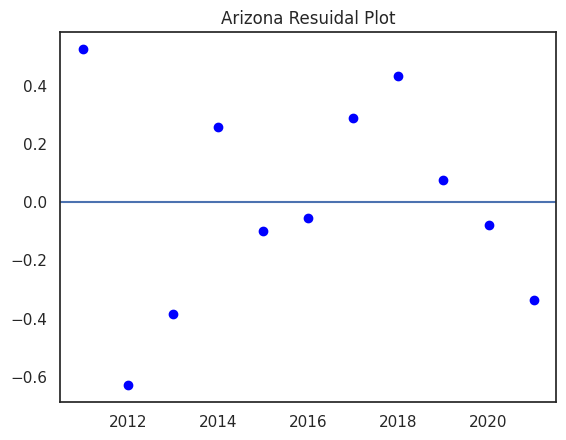

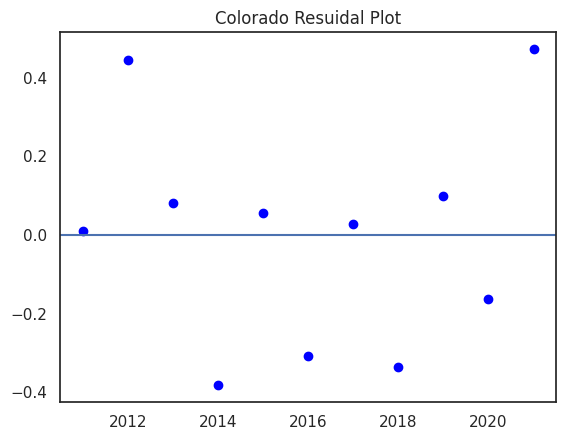

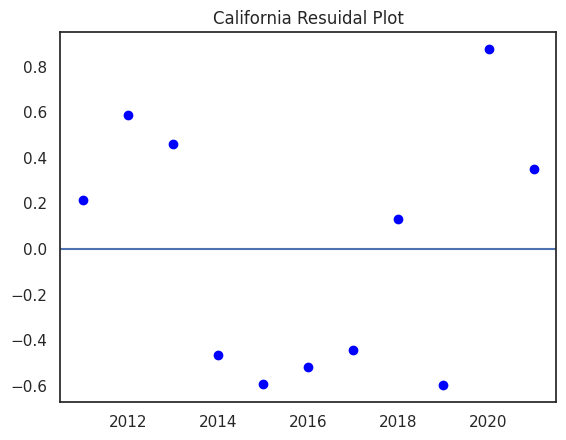

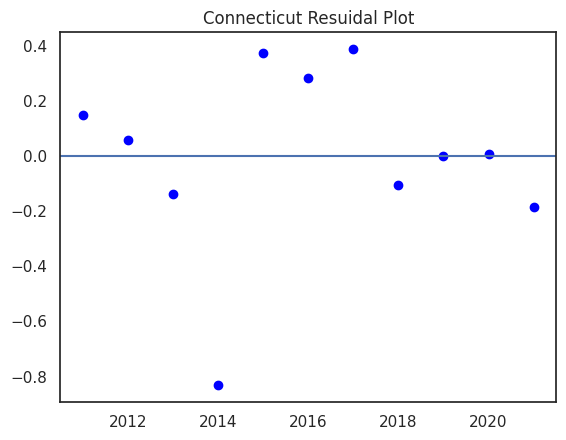

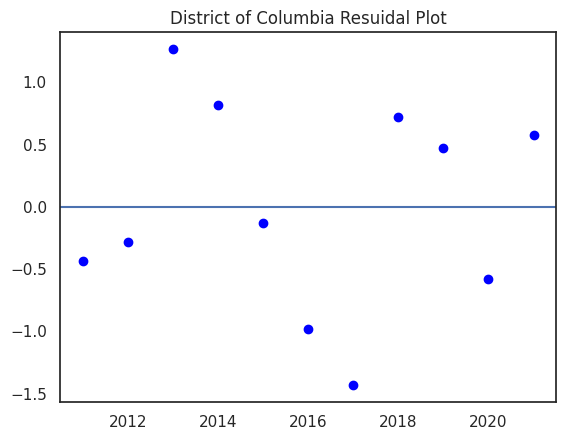

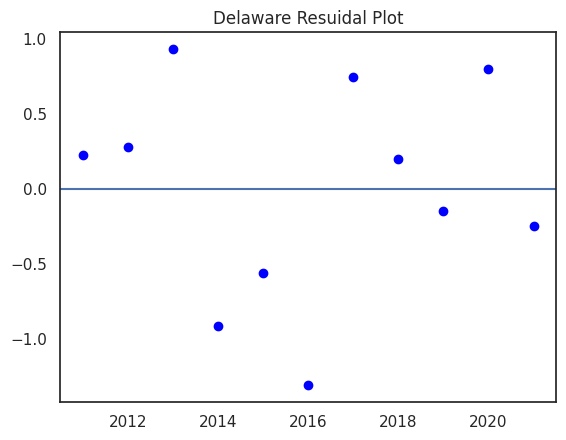

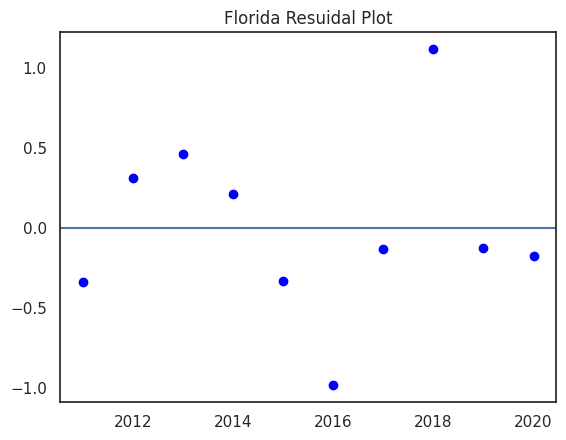

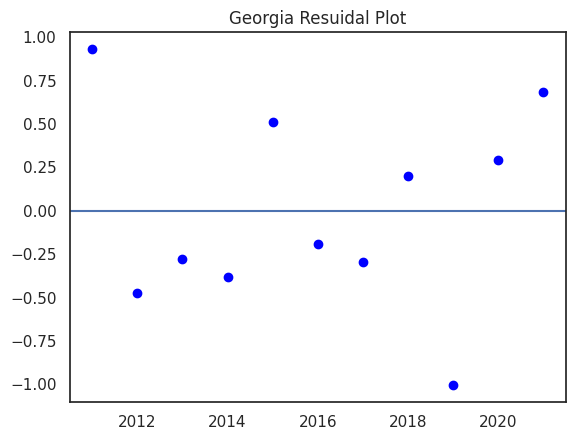

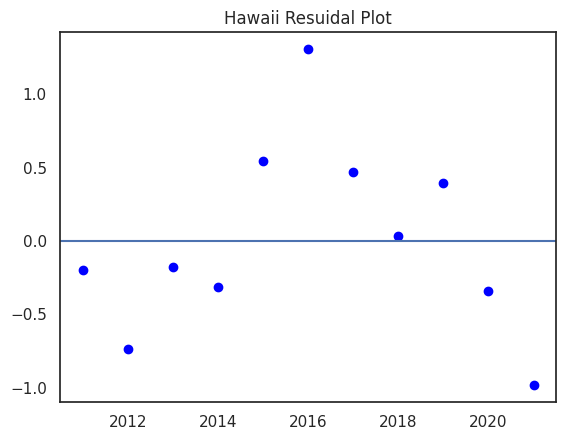

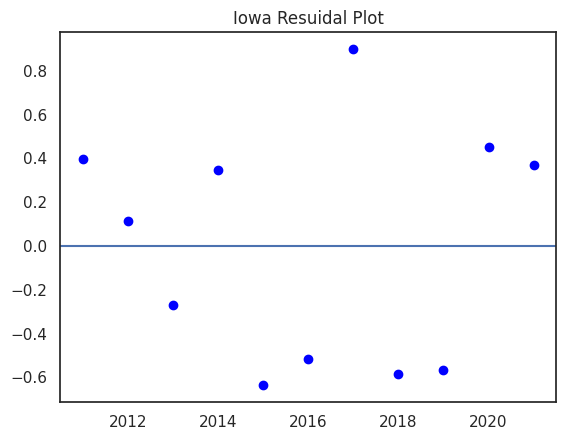

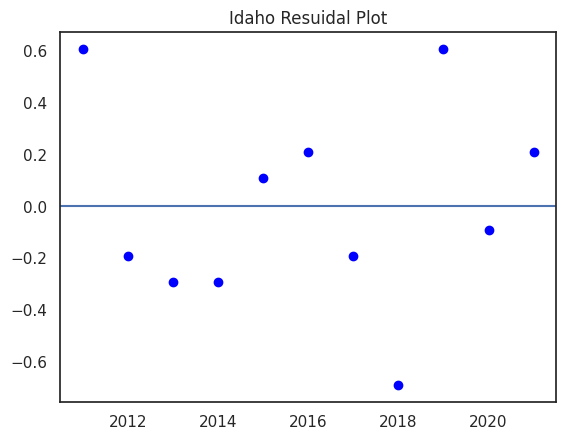

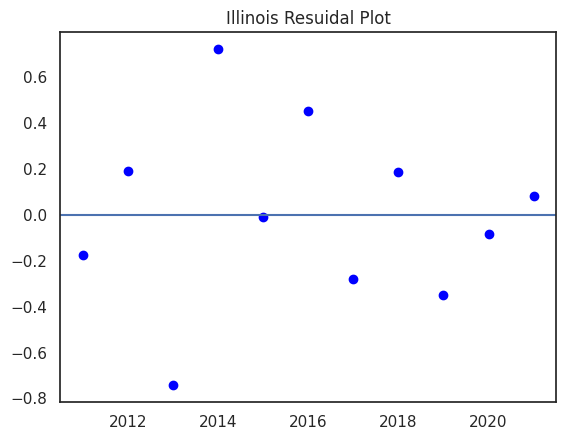

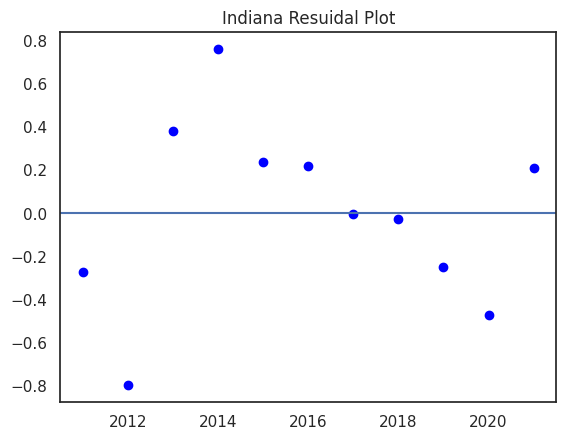

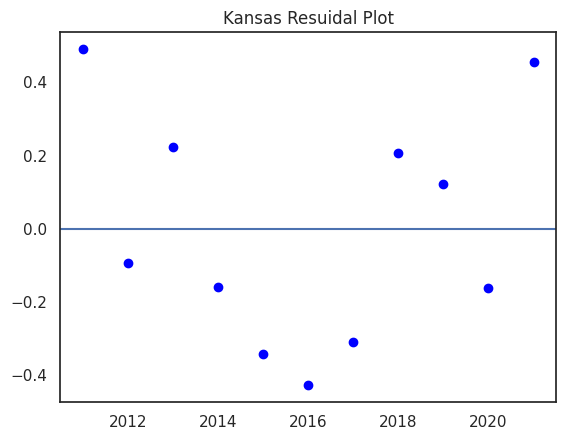

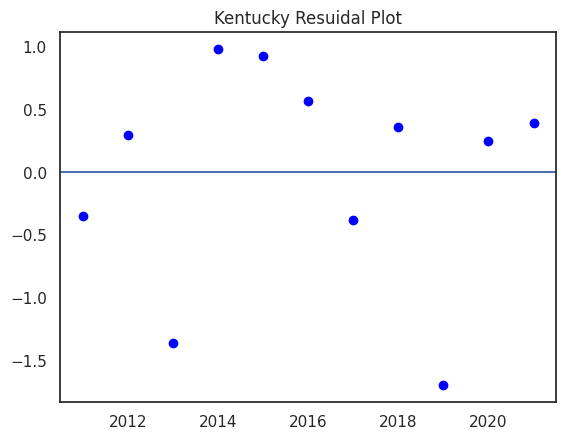

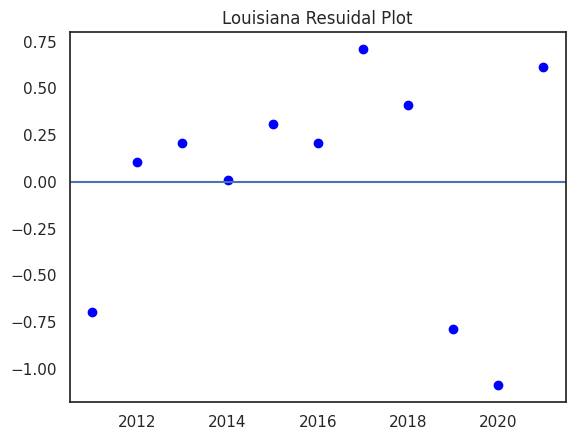

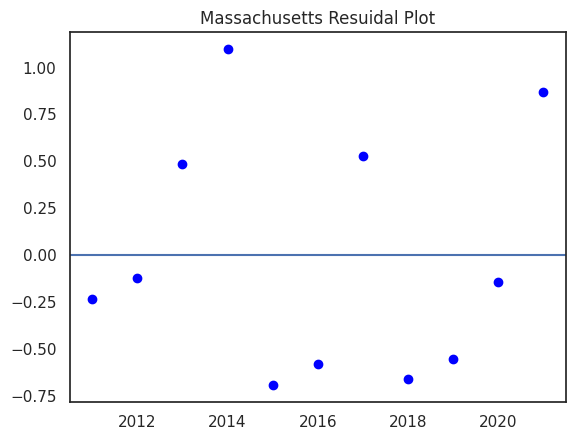

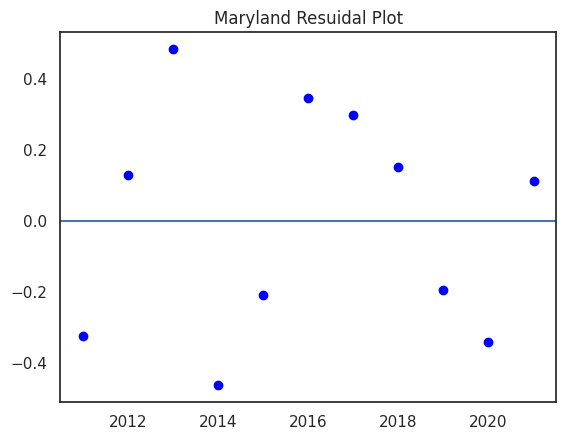

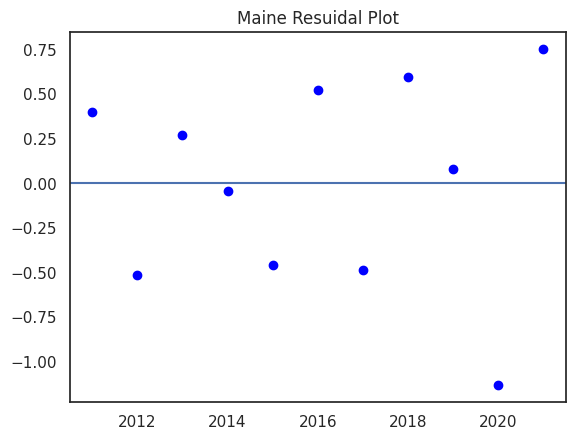

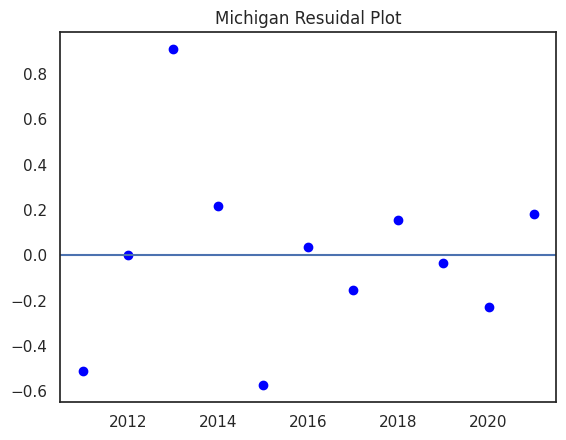

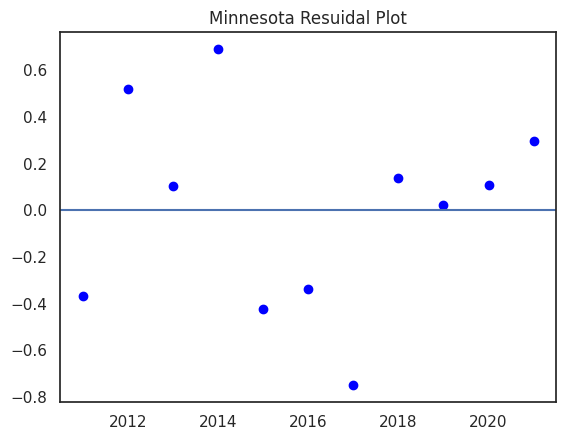

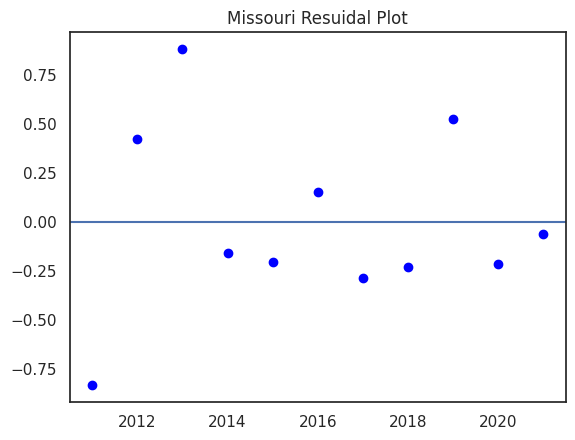

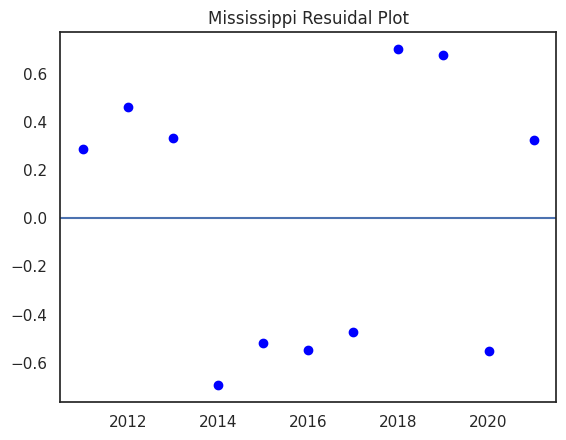

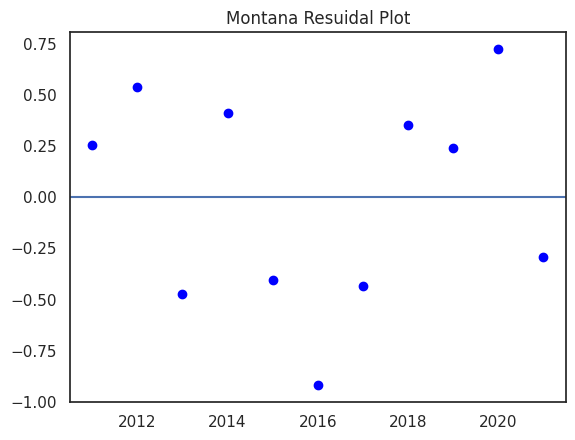

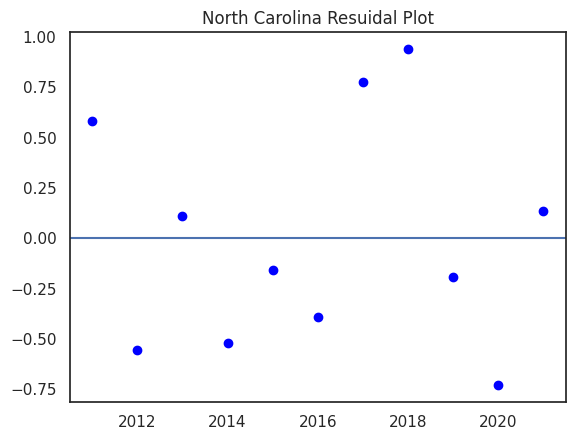

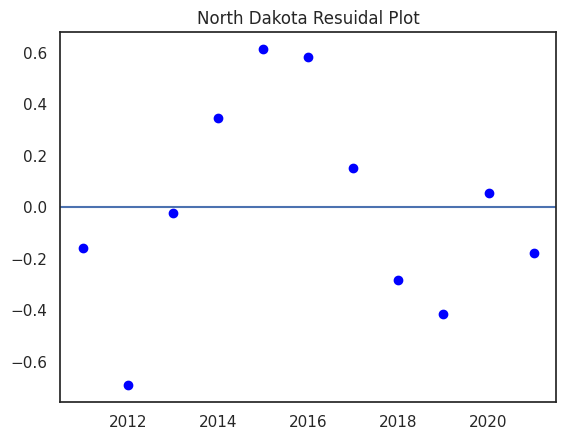

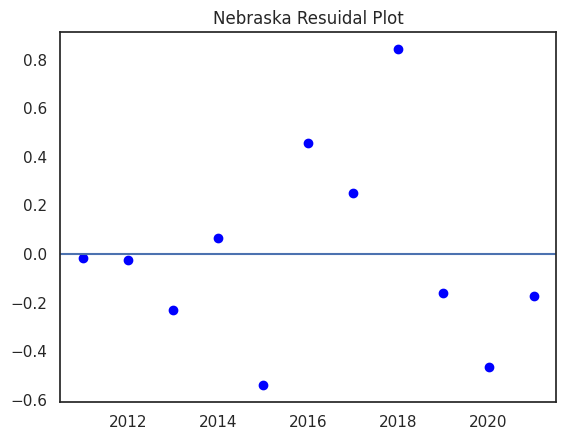

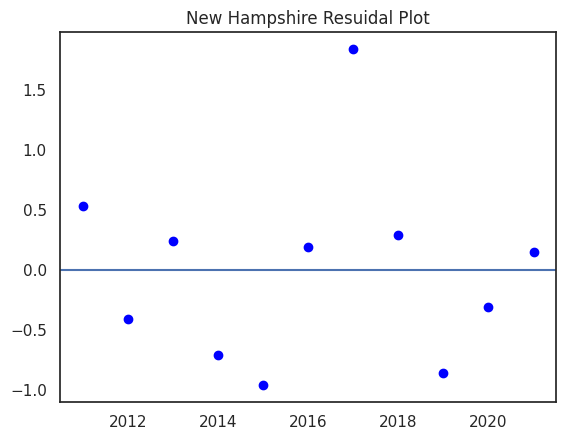

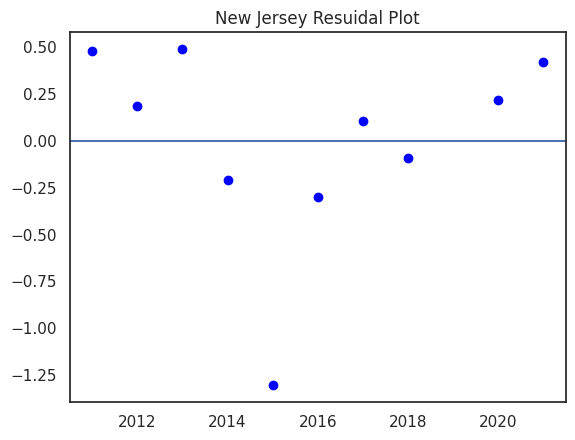

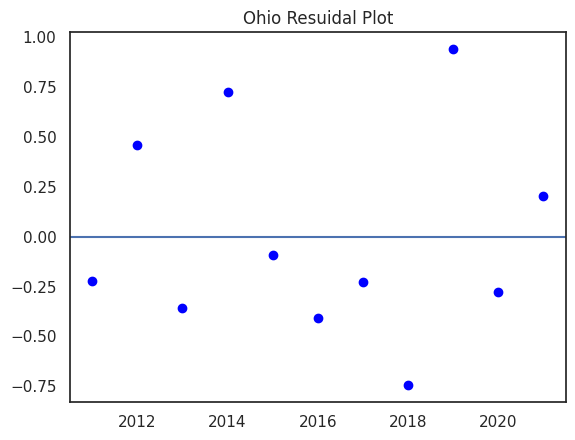

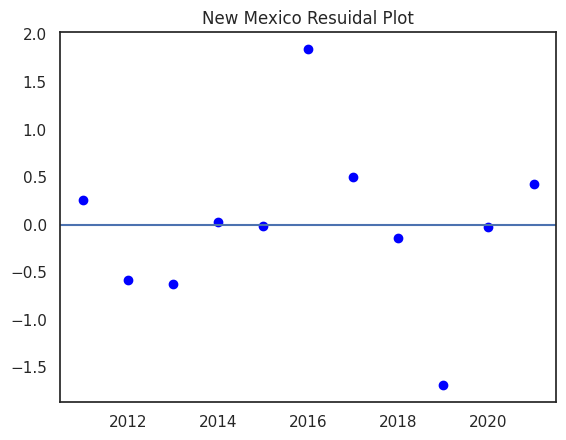

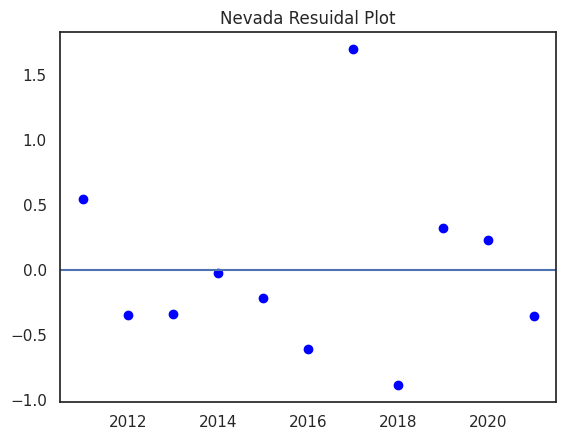

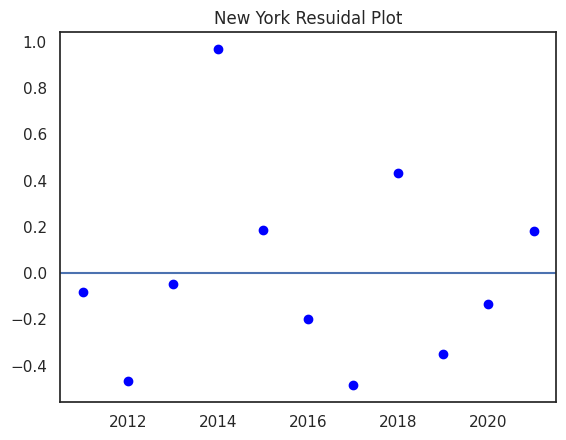

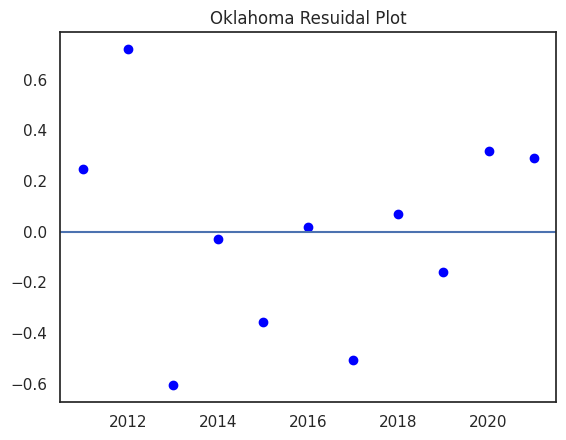

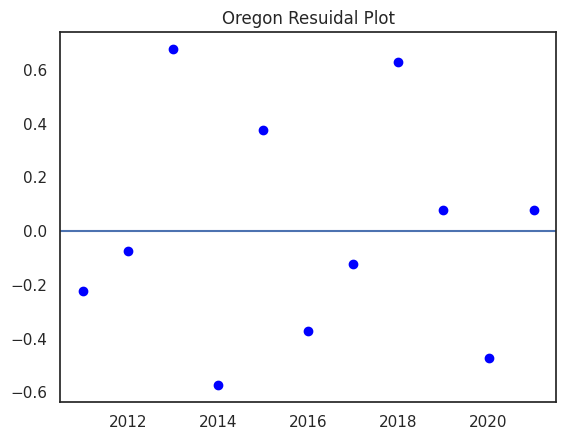

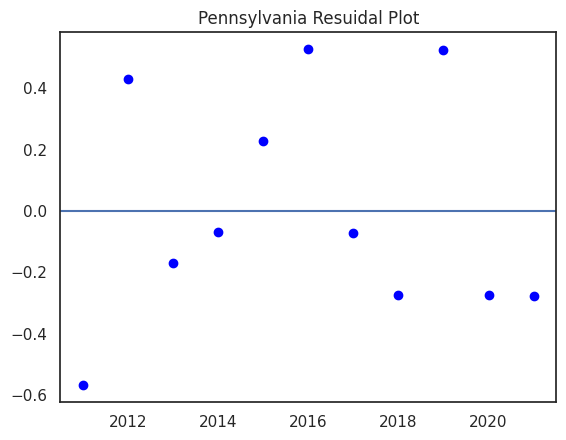

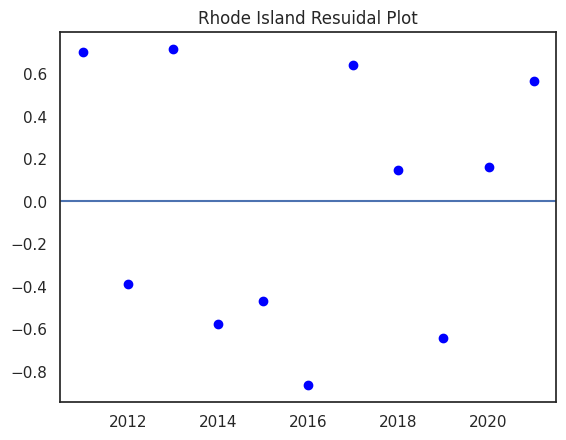

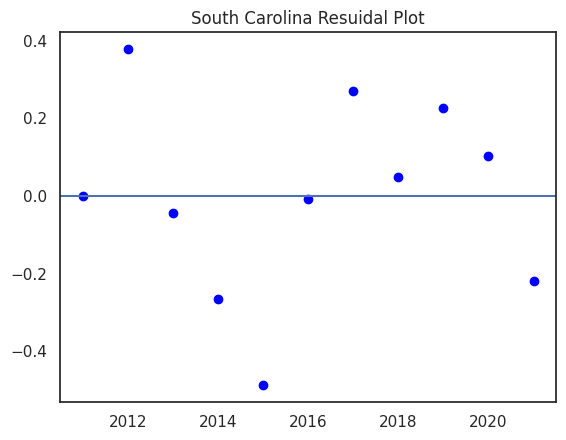

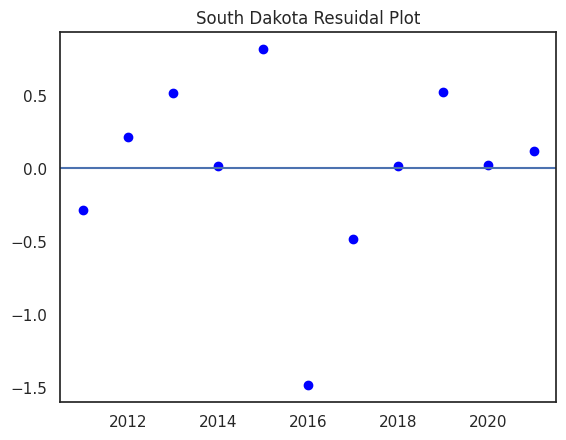

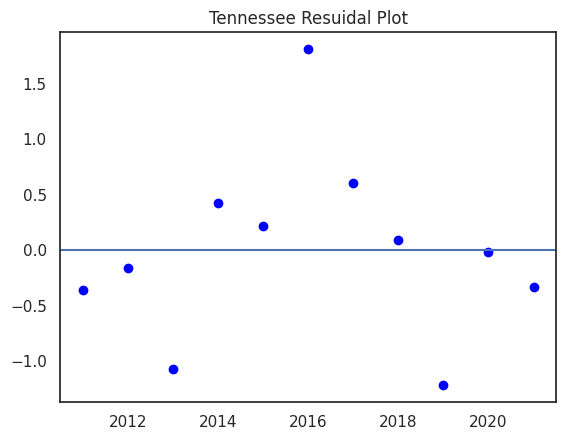

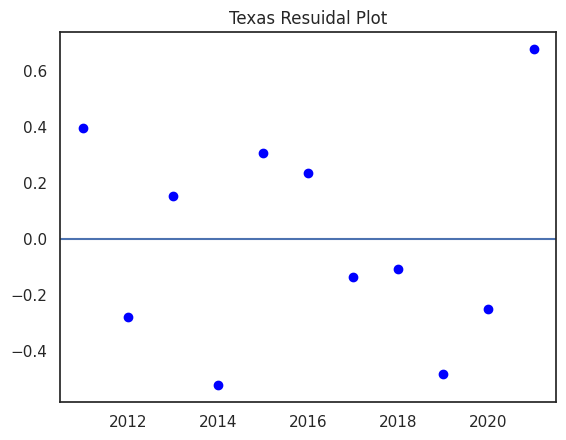

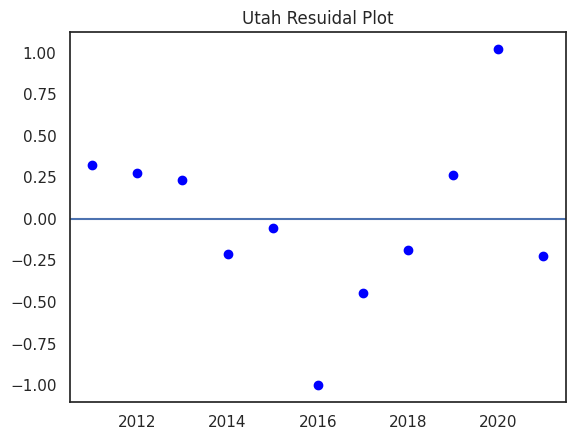

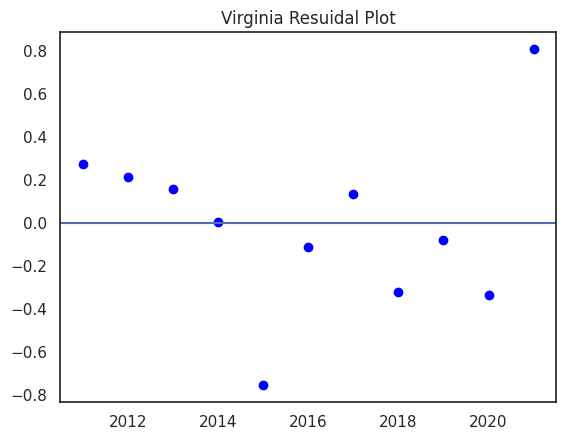

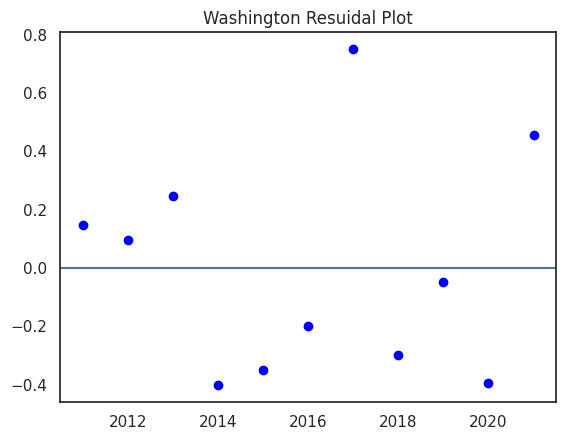

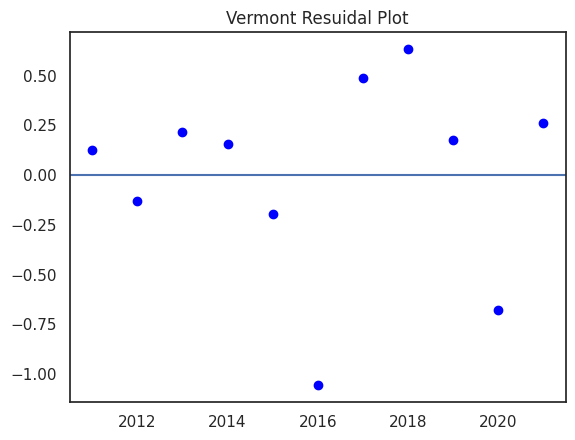

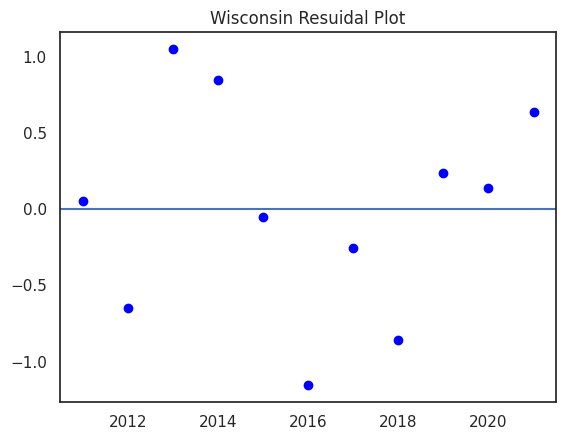

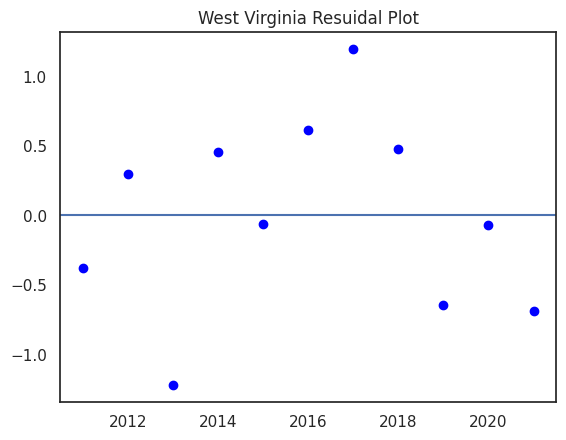

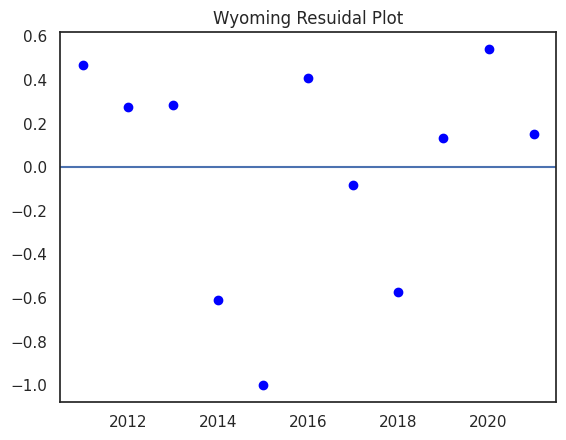

In [51]:
results = []
lrAssump = []
states = df_asth[df_asth['State'] != 'United States']
for i in states['State'].unique():
  state_data =df_asth[df_asth['State'] == i]
  X = state_data[['Year']]
  Y = state_data['Asthma_Prev']
  x = sm.add_constant(X)
  lr = sm.OLS(Y,x).fit()
  plt.scatter(X,lr.resid,color='blue')
  plt.title(f'{i} Resuidal Plot')
  plt.axhline(y=0)
  plt.show()
  rej = 0

  dw = durbin_watson(lr.resid) #indepence test on residuals
  bp_stat, bp_p, _, _ = het_breuschpagan(lr.resid, x) #homestacity test on residuals
  lrAssump.append({'State': i,
      'DW_stat': dw,
                  'DW_ok':1.5 <= dw <= 2.5,
                  'BP_pval': bp_p,
                  'Homoscedastic': bp_p >0.05})
  suma = lr.summary2().tables[1]



  results.append({'State':i,
                  'Beta0':lr.params['const'],
                  'Beta1':lr.params['Year'],
                  'Std_error':suma.loc['Year','Std.Err.'],
                  'Pvalue': suma.loc['Year','P>|t|'],
                  'sigma': lr.resid.std(),
                  'R^2':lr.rsquared,
                  'N_years':len(X),
                  'Pass_Thres': suma.loc['Year','P>|t|'] < .05})


res = pd.DataFrame(results)
lrAssump= pd.DataFrame(lrAssump)
res['trend_der'] = res['Beta1'].apply(lambda x:'Inc' if x > 0 else 'Dec')

In [52]:
def MC_power_calc(state):
  rej = 0
  state_data_power = df_asth[df_asth['State'] == state]
  state_res = res[res['State'] == state]
  year = state_data_power[['Year']]
  x = sm.add_constant(year)
  for _ in range(1000):
    y = state_res['Beta0'].values+state_res['Beta1'].values*year.values.flatten() + np.random.normal(0,state_res['sigma'].values[0], size=len(year))
    sim = sm.OLS(y,x).fit()
    if sim.pvalues['Year'] < .05:
      rej += 1
  power = rej/1000
  return power

In [55]:
res['Power'] = res['State'].apply(MC_power_calc)

In [56]:
res['Bon_.05'] = bonferroni_correction(res.Pvalue,.05)
res['BH_.05'] = benj_h_or_y(res.Pvalue,.05)
res['BY_.05'] = benj_h_or_y(res.Pvalue,.05,True)
res

,State,Beta0,Beta1,Std_error,Pvalue,sigma,R^2,N_years,Pass_Thres,trend_der,Power,Bon_.05,BH_.05,BY_.05
0,Alaska,-115.716364,0.061818,0.048500,0.234373,0.482569,0.152910,11,False,Inc,0.232,False,False,False
1,Alabama,-322.250909,0.164545,0.069946,0.043131,0.695956,0.380765,11,True,Inc,0.568,False,False,False
2,Arkansas,-49.483636,0.029091,0.054978,0.609512,0.547025,0.030171,11,False,Inc,0.092,False,False,False
3,Arizona,-104.174545,0.056364,0.036207,0.153963,0.360252,0.212141,11,False,Inc,0.321,False,False,False
4,Colorado,-320.781818,0.163636,0.028844,0.000304,0.286991,0.781476,11,True,Inc,1.000,True,True,True
5,California,-44.830909,0.026364,0.054122,0.637822,0.538508,0.025687,11,False,Inc,0.079,False,False,False
6,Connecticut,-178.552727,0.093636,0.034111,0.022659,0.339398,0.455713,11,True,Inc,0.720,False,False,False
7,District of Columbia,-88.185455,0.049091,0.083915,0.572914,0.834941,0.036633,11,False,Inc,0.089,False,False,False
8,Delaware,-85.492727,0.047273,0.072358,0.529885,0.719949,0.045278,11,False,Inc,0.095,False,False,False
9,Florida,111.538788,-0.051515,0.065944,0.457178,0.564708,0.070877,10,False,Dec,0.117,False,False,False


In [57]:
lrAssump

,State,DW_stat,DW_ok,BP_pval,Homoscedastic
0,Alaska,2.436947,True,0.812878,True
1,Alabama,1.837384,True,0.342409,True
2,Arkansas,2.464816,True,0.316293,True
3,Arizona,2.446519,True,0.050213,True
4,Colorado,2.120409,True,0.659796,True
5,California,2.293033,True,0.336596,True
6,Connecticut,1.956820,True,0.501328,True
7,District of Columbia,2.110276,True,0.914209,True
8,Delaware,2.322899,True,0.761868,True
9,Florida,1.983672,True,0.542566,True


In [58]:
print('States which do not have indepence of errors:',np.array(lrAssump[lrAssump['DW_ok']== False]['State']))
print('States which are not Homoscedastic:',np.array(lrAssump[lrAssump['Homoscedastic']== False]['State']))

States which do not have indepence of errors: ['Hawaii' 'Iowa' 'Idaho' 'Massachusetts' 'Maryland' 'Maine' 'Mississippi'
 'Montana' 'North Dakota' 'New Hampshire' 'New Jersey' 'Ohio' 'New Mexico'
 'Nevada' 'Oklahoma' 'Virginia']
States which are not Homoscedastic: []


In [59]:
print('States that reject with no Correction:',np.array(res[res['Pass_Thres']]['State']))
print('States that pass after Boneferri Correction:',np.array(res[res['Bon_.05']]['State']))
print('States that pass after Benjimini-Hochberg:',np.array(res[res['BH_.05']]['State']))
print('States that pass after Benjimini-Yukitieli:',np.array(res[res['BY_.05']]['State']))

States that reject with no Correction: ['Alabama' 'Colorado' 'Connecticut' 'Idaho' 'Kansas' 'Louisiana'
 'Michigan' 'Minnesota' 'Mississippi' 'Nebraska' 'Nevada' 'Oklahoma'
 'Pennsylvania' 'South Carolina' 'Tennessee' 'Utah' 'West Virginia']
States that pass after Boneferri Correction: ['Colorado' 'Kansas' 'South Carolina']
States that pass after Benjimini-Hochberg: ['Colorado' 'Kansas' 'Mississippi' 'South Carolina' 'Tennessee'
 'West Virginia']
States that pass after Benjimini-Yukitieli: ['Colorado' 'Kansas']


In [60]:
print('State with a decreasing Trend', print(np.array(res[res['trend_der']== 'Dec']['State'])))

['Florida' 'Hawaii' 'Massachusetts' 'Missouri' 'New Jersey' 'New York']
State with a decreasing Trend None


# RQ2

In [61]:
df_merged = pd.merge(df_asth, df_smok, on=["Year", "State", "LocationAbbr", "Region"], how="inner")
df_merged = df_merged[["Year", "State", "LocationAbbr", "Region", "Asthma_Prev", "Smoking_Prev"]]
df = df_merged.copy()

In [62]:
df["asthma_prop"] = df["Asthma_Prev"] / 100.0
df["smoking_prop"] = df["Smoking_Prev"] / 100.0
df["logit_asthma_prop"] = np.log(df["asthma_prop"] / (1 - df["asthma_prop"]))

overall_mean_prev = df[df['LocationAbbr'] == 'US']['asthma_prop'].mean()
overall_mean_logit = np.log(overall_mean_prev / (1 - overall_mean_prev))

df = df[df['State'] != 'United States']

states, state_idx = np.unique(df["State"].values, return_inverse=True)
years, year_idx = np.unique(df["Year"].values, return_inverse=True)

In [63]:
with pm.Model() as model:
    mu_alpha = pm.Normal("mu_alpha", mu=overall_mean_logit, sigma=0.5)
    sigma_alpha = pm.Uniform("sigma_alpha", 0, 1)
    sigma_delta = pm.Uniform("sigma_delta", 0, 0.5)
    sigma = pm.Uniform("sigma", 0, 3)

    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, shape=len(states))
    delta = pm.Normal("delta", mu=0, sigma=sigma_delta, shape=len(years))
    beta = pm.Normal("beta", mu=0, sigma=3)

    conditional_mean = alpha[state_idx] + delta[year_idx] + beta * df["smoking_prop"].values
    y_obs = pm.Normal("y_obs", mu=conditional_mean, sigma=sigma, observed=df["logit_asthma_prop"].values)

    trace = pm.sample(draws=4000, tune=4000, chains=4, target_accept=0.99, return_inferencedata=True, random_seed=88)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


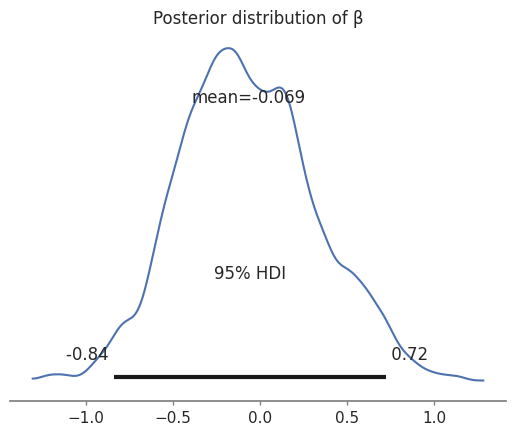

β summary:


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,-0.069,0.402,-0.841,0.723,0.04,0.016,110.0,443.0,1.04


Posterior mean for beta: -0.06918533441488536
Posterior median for beta: -0.09357786379398243
(2.5%, 97.5%) quantiles: -0.8182920684331055 0.7501427807610835


In [64]:
# Beta analysis
az.plot_posterior(trace, var_names=["beta"], hdi_prob=0.95)
plt.title("Posterior distribution of β")
plt.show()

beta_summary = pd.DataFrame(az.summary(trace, var_names=["beta"], hdi_prob=0.95))
print("β summary:")
display(beta_summary)

beta_samples = trace.posterior["beta"].values.flatten()
beta_mean = beta_samples.mean()
beta_median = np.median(beta_samples)
beta_q_low, beta_q_high = np.quantile(beta_samples, [0.025, 0.975])

print("Posterior mean for beta:", beta_mean)
print("Posterior median for beta:", beta_median)
print("(2.5%, 97.5%) quantiles:", beta_q_low, beta_q_high)

In [65]:
# alpha_s analysis
alpha_samples = trace.posterior["alpha"].values
n_chains, n_draws, n_states = alpha_samples.shape
alpha_flat = alpha_samples.reshape(n_chains * n_draws, n_states)

alpha_means = alpha_flat.mean(axis=0)
alpha_medians = np.median(alpha_flat, axis=0)
alpha_quantiles = np.quantile(alpha_flat, [0.025, 0.25, 0.5, 0.75, 0.975], axis=0)

def sigmoid(x): return 1 / (1 + np.exp(-x))

alpha_means_prev = sigmoid(alpha_means) * 100
alpha_medians_prev = sigmoid(alpha_medians) * 100
alpha_q_low_prev = sigmoid(alpha_quantiles[0]) * 100
alpha_q25_prev = sigmoid(alpha_quantiles[1]) * 100
alpha_q50_prev = sigmoid(alpha_quantiles[2]) * 100
alpha_q75_prev = sigmoid(alpha_quantiles[3]) * 100
alpha_qhigh_prev = sigmoid(alpha_quantiles[4]) * 100

df_alpha_summary = pd.DataFrame({
    "state": states,
    "mean_prev": alpha_means_prev,
    "median_prev": alpha_medians_prev,
    "q2.5_prev": alpha_q_low_prev,
    "q25_prev": alpha_q25_prev,
    "q50_prev": alpha_q50_prev,
    "q75_prev": alpha_q75_prev,
    "q97.5_prev": alpha_qhigh_prev,
}).round(1)

df_alpha_summary = df_alpha_summary.sort_values(by="mean_prev")

print("Posterior summary for each α_s")
display(df_alpha_summary)

Posterior summary for each α_s


,state,mean_prev,median_prev,q2.5_prev,q25_prev,q50_prev,q75_prev,q97.5_prev
43,Texas,7.5,7.5,6.6,7.2,7.5,7.8,8.4
41,South Dakota,7.8,7.8,6.7,7.4,7.8,8.2,8.9
9,Florida,7.9,7.9,6.9,7.6,7.9,8.2,8.8
23,Minnesota,8.0,8.1,7.0,7.7,8.1,8.4,9.0
27,Nebraska,8.0,8.0,6.9,7.6,8.0,8.3,9.0
18,Louisiana,8.2,8.2,6.9,7.8,8.2,8.7,9.6
15,Iowa,8.4,8.5,7.3,8.1,8.5,8.8,9.5
4,California,8.4,8.4,7.6,8.1,8.4,8.7,9.2
34,North Dakota,8.5,8.6,7.3,8.1,8.6,9.0,9.8
33,North Carolina,8.5,8.5,7.3,8.1,8.5,8.9,9.7


In [66]:
convert_to_abbrev = df[["State", "LocationAbbr"]].drop_duplicates("State").set_index('State')
convert_to_abbrev = convert_to_abbrev.to_dict()['LocationAbbr']
df_alpha_summary['LocationAbbr'] = df_alpha_summary['state'].map(convert_to_abbrev)
df_alpha_summary['Region'] = df_alpha_summary['LocationAbbr'].apply(get_region)
df_alpha_summary

,state,mean_prev,median_prev,q2.5_prev,q25_prev,q50_prev,q75_prev,q97.5_prev,LocationAbbr,Region
43,Texas,7.5,7.5,6.6,7.2,7.5,7.8,8.4,TX,South (West South Central)
41,South Dakota,7.8,7.8,6.7,7.4,7.8,8.2,8.9,SD,Midwest (West North Central)
9,Florida,7.9,7.9,6.9,7.6,7.9,8.2,8.8,FL,South (South Atlantic)
23,Minnesota,8.0,8.1,7.0,7.7,8.1,8.4,9.0,MN,Midwest (West North Central)
27,Nebraska,8.0,8.0,6.9,7.6,8.0,8.3,9.0,NE,Midwest (West North Central)
18,Louisiana,8.2,8.2,6.9,7.8,8.2,8.7,9.6,LA,South (West South Central)
15,Iowa,8.4,8.5,7.3,8.1,8.5,8.8,9.5,IA,Midwest (West North Central)
4,California,8.4,8.4,7.6,8.1,8.4,8.7,9.2,CA,Pacific
34,North Dakota,8.5,8.6,7.3,8.1,8.6,9.0,9.8,ND,Midwest (West North Central)
33,North Carolina,8.5,8.5,7.3,8.1,8.5,8.9,9.7,NC,South (South Atlantic)


In [67]:
mean_of_post_med_alpha = df_alpha_summary.groupby('Region')[['median_prev']].mean().rename(columns={'median_prev': 'average_median_prev'})
mean_of_post_med_alpha.sort_values(by='average_median_prev')

,average_median_prev
Region,
Midwest (West North Central),8.600000
South (West South Central),8.775000
West (Mountain),9.325000
South (South Atlantic),9.366667
Mid-Atlantic,9.533333
Pacific,9.580000
South (East South Central),9.675000
Midwest (East North Central),9.960000
Northeast,11.200000
